In [1]:
# Setup scenario
from copy import deepcopy
from pathlib import Path

from constants import DATA_ENTITIES_DIR, DATA_HAZARDS_DIR, DATA_TEMP_DIR, REQUIREMENTS_DIR
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from climada.engine import CostBenefit, Impact, ImpactCalc
from climada.engine.cost_benefit import risk_aai_agg
from climada.entity import DiscRates, Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
from climada.entity.measures import Measure, MeasureSet
from climada.hazard import Hazard
from climada.util.api_client import Client

from costben.costben_handler import CostBenefitHandler
from entity.entity_handler import EntityHandler
from exposure.exposure_handler import ExposureHandler
from hazard.hazard_handler import HazardHandler
from impact.impact_handler import ImpactHandler

import handlers
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])

costben_handler = CostBenefitHandler()
entity_handler = EntityHandler()
exposure_handler = ExposureHandler()
hazard_handler = HazardHandler()
impact_handler = ImpactHandler()


# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"  # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"  # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
scenario = "rcp26"  # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"  # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']
annual_growth = 1.01

client = Client()

(<GeoAxesSubplot:title={'center':'Return period: 10 years'}>,
 array([[0., 0., 0., ..., 0., 0., 0.]]))

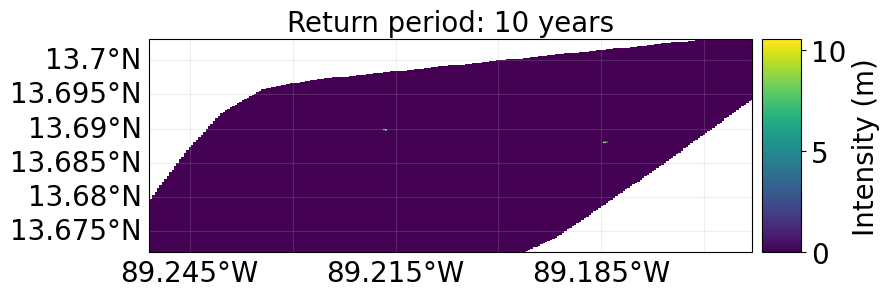

In [47]:
haz = Hazard().from_mat(DATA_HAZARDS_DIR / "Salvador_hazard_FL_2040_extreme_cc.mat")
haz.check()
haz.plot_rp_intensity((10,))

In [66]:
import h5py
from scipy.io import whosmat, loadmat

# Keys
['centroid_ID', 'comment', 'date', 'datenum', 'dd', 'event_ID', 'event_count', 'filename', 'frequency', 
 'intensity', 'lat', 'lati', 'lon', 'long', 'matrix_density', 'mm', 'name', 'orig_event_count', 'orig_event_flag', 
 'orig_years', 'orig_yearset', 'peril_ID', 'reference_year', 'units', 'windfield_comment', 'yyyy']

def get_hazard_from_mat(file_path):
    with h5py.File(file_path, 'r') as file:
        hazard_data = file['hazard']
        hazard = Hazard()
        hazard.centroids = np.array(hazard_data['centroid_ID'])
        hazard.intensity = np.array(hazard_data['intensity']['data'])
        hazard.event_id = np.array(hazard_data['event_ID'])
        hazard.date = np.array(hazard_data['date'])
        hazard.frequency = np.array(hazard_data['frequency'])
        # match all the other attributes
        
        return hazard
    

def check_mat_version(file_path):
    try:
        # Attempt to load the .mat file metadata
        mat_info = whosmat(file_path)
        print(f".mat file version is 7.2 or earlier. Contents: {mat_info}")
    except NotImplementedError as e:
        print(".mat file is version 7.3 or later (HDF5 format).")





file_path = DATA_HAZARDS_DIR / 'hazard_Thailand_RCP85_gev_RP10.mat'
check_mat_version(file_path)


.mat file is version 7.3 or later (HDF5 format).


In [2]:
# Example
ent = entity_handler.get_entity_from_xlsx(DATA_ENTITIES_DIR / "4_entity_TODAY_THAI_Flood_USD_1.xlsx")
ent.check()
ent.exposures.ref_year = 2024

ent_future = entity_handler.get_future_entity(ent, 2040, 1.02)

haz = client.get_hazard(hazard_type="flood", properties={"country_name": "Thailand"})
haz.check()

haz_future = deepcopy(haz)

costben = costben_handler.calculate_cost_benefit(
    hazard_present=haz,
    entity_present=ent, 
    hazard_future=None, 
    entity_future=ent_future, 
    future_year=2040,
)

costben_handler.plot_cost_benefit(costben)
costben_handler.plot_waterfall(costben, haz, ent, haz_future, ent_future)



Measure                       Cost (USD m)    Benefit (USD m)    Benefit/Cost
--------------------------  --------------  -----------------  --------------
beach nourishment                  40.5725           131.973        3.25277
sandbags                           22.3888            25.0749       1.11997
seawall                           731.904             98.2904       0.134294
elevate existing buildings       3911.96             131.973        0.0337358
enforce building code              10                  0            0

--------------------  ----------  -------
Total climate risk:    131.973    (USD m)
Average annual risk:     8.91072  (USD m)
Residual risk:        -255.338    (USD m)
--------------------  ----------  -------
Net Present Values


<AxesSubplot:title={'center':'Risk at 2024 and 2040'}, ylabel='Impact (USD m)'>

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "exposures"
]
hazard_data_types = [
    data_type_info.data_type
    for data_type_info in data_type_infos
    if data_type_info.data_type_group == "hazard"
]

print(
    f"Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}")

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        "country_name": country_name,
    }
)

exposure_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "exposures"
        ]
    )
)
hazard_data_types = list(
    set(
        [
            dataset_info.data_type.data_type
            for dataset_info in dataset_infos
            if dataset_info.data_type.data_type_group == "hazard"
        ]
    )
)

print(
    f"Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}")
print(
    f"Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}")

In [ ]:
# Available climate scenarios and time horizons for specific hazard type in countries Thailand and Egypt
if hazard_type == "river_flood" or "wildfire":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "tropical_cyclone":
    available_scenarios = list(
        set(
            [
                dataset_info.properties["climate_scenario"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
    available_time_horizons = list(
        set(
            [
                dataset_info.properties.get("ref_year")
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )
if hazard_type == "earthquake":
    available_scenarios = []
    available_time_horizons = []
if hazard_type == "flood":
    available_scenarios = []
    available_time_horizons = list(
        set(
            [
                dataset_info.properties["year_range"]
                for dataset_info in dataset_infos
                if dataset_info.data_type.data_type == hazard_type
            ]
        )
    )

print(
    f"Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}"
)
print(
    f"Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}"
)

In [21]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": hazard_type,
        "country_name": country_name,
        # "climate_scenario": climate_scenario,
    }
)
hazard_dataset_infos

[DatasetInfo(uuid='b87599b9-a996-43c2-8e6c-4123c0f87174', data_type=DataTypeShortInfo(data_type='flood', data_type_group='hazard'), name='flood_THA', version='v1', status='active', properties={'res_meter': '250', 'climada_version': 'v3.1.2', 'spatial_coverage': 'country', 'year_range': '2002_2019', 'country_iso3alpha': 'THA', 'country_name': 'Thailand', 'country_iso3num': '764', 'date_creation': '2022-9-30'}, files=[FileInfo(uuid='b87599b9-a996-43c2-8e6c-4123c0f87174', url='https://data.iac.ethz.ch/climada/b87599b9-a996-43c2-8e6c-4123c0f87174/flood_THA.hdf5', file_name='flood_THA.hdf5', file_format='hdf5', file_size=220915666, check_sum='md5:fbe8c273bc05721caf14dcf7384746f7')], doi=None, description='Flood footprints of historical events based on the cloud to street database https://www.cloudtostreet.ai.', license='Attribution 4.0 International (CC BY 4.0)', activation_date='2022-10-25 09:09:25.359138+00:00', expiration_date=None)]

In [ ]:
# Get Exposure
# Available Exposures: ['litpop']
exposure_present = exposure_handler.get_exposure(country_name)
if annual_growth > 1:
    exposure_future = exposure_handler.get_growth_exposure(
        exposure_present, annual_growth, 2040)

In [ ]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard_present = hazard_handler.get_hazard(
    hazard_type,
    "historical",
    "1980_2000",
    country_name,
)

if scenario != "historical":
    hazard_future = hazard_handler.get_hazard(
        hazard_type,
        scenario,
        time_horizon,
        country_name,
    )

In [ ]:
# Get Impact
impact_function_set = impact_handler.calculate_impact_function_set(hazard_present)
impact_present = impact_handler.calculate_impact(exposure_present, hazard_present, impact_function_set)

if scenario != "historical":
    if annual_growth > 1:
        impact_future = impact_handler.calculate_impact(
            exposure_future, hazard_future, impact_function_set)
    impact_future = impact_handler.calculate_impact(
        exposure_present, hazard_future, impact_function_set)

In [ ]:
measure_set = costben_handler.get_measure_set_from_excel('RF')
discount_rates = costben_handler.get_discount_rates_from_excel()

In [ ]:
import pandas as pd
import sqlite3

class DataFrameSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def save_dataframe(self, df, table_name):
        """
        Save a DataFrame to the SQLite database.
        
        :param df: DataFrame to save.
        :param table_name: Name of the table to save the DataFrame to.
        """
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"DataFrame saved to {table_name} table.")

    def read_dataframe(self, table_name):
        """
        Read a DataFrame from the SQLite database.
        
        :param table_name: Name of the table to read the DataFrame from.
        :return: DataFrame read from the database.
        """
        with sqlite3.connect(self.db_path) as conn:
            df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
        return df

# Example usage
db_path = 'my_data.db'  # Path to your SQLite database file
df_sqlite = DataFrameSQLite(db_path)

# Assuming you have a DataFrame `df` to save
df_sqlite.save_dataframe(exp_gdf, 'exposure')

# To read the saved DataFrame from the database
df_read = df_sqlite.read_dataframe('exposure')
print(df_read)


In [83]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_to_df(self, excel_path, sheet_name):
        """Reads a specified sheet from an Excel file into a DataFrame."""
        return pd.read_excel(excel_path, sheet_name=sheet_name)

    def adjust_df_columns(self, df, columns_to_keep=None):
        """Adjusts DataFrame columns based on the provided list. If None, keeps all columns."""
        if columns_to_keep is not None:
            df = df[columns_to_keep]
        return df

    def save_df_to_sqlite(self, df, table_name):
        """Saves a DataFrame to an SQLite table, appending data if the table already exists."""
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists="append", index=False)

    def read_table(self, table_name):
        """Reads a table from SQLite database into a DataFrame."""
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
excel_to_sqlite = ExcelToSQLite(db_path)

# Define the sheets and corresponding table names
sheets_tables = {
    "assets": "exposures",
    "impact_functions": "impact_functions",
    "measures": "measures",
    "discount": "discount_rates",
    "names": "names",
}

# Iterate over sheets and tables, read, adjust (if needed), and save to SQLite
for sheet, table in sheets_tables.items():
    df = excel_to_sqlite.read_excel_to_df(excel_path, sheet)

    # Here you can define which columns to keep for each table if needed, e.g.:
    # if table == 'exposures':
    #     columns_to_keep = ['Column1', 'Column2']
    #     df = excel_to_sqlite.adjust_df_columns(df, columns_to_keep)
    # else:
    #     df = excel_to_sqlite.adjust_df_columns(df)

    excel_to_sqlite.save_df_to_sqlite(df, table)

In [ ]:
import pandas as pd
import sqlite3


class ExcelToSQLite:
    def __init__(self, db_path):
        self.db_path = db_path

    def read_excel_and_save(self, excel_path, tabs_columns_mapping):
        """
        Read specified tabs from an Excel file and save them to SQLite database.

        :param excel_path: Path to the Excel file.
        :param tabs_columns_mapping: Dict mapping tab names to their columns adjustments.
        """
        with sqlite3.connect(self.db_path) as conn:
            for tab, columns in tabs_columns_mapping.items():
                df = pd.read_excel(excel_path, sheet_name=tab)

                # Adjust columns if specified
                if columns:
                    df = df[columns]

                df.to_sql(tab, conn, if_exists="append", index=False)
                print(f"Data from {tab} tab saved to {tab} table.")

    def read_table(self, table_name):
        """
        Read data from a specified table in the SQLite database.

        :param table_name: Name of the table to read data from.
        :return: DataFrame with the table data.
        """
        with sqlite3.connect(self.db_path) as conn:
            return pd.read_sql(f"SELECT * FROM {table_name}", conn)


# Example usage
db_path = "climadera.db"  # Path to your SQLite database file
excel_path = DATA_ENTITIES_DIR / "3_entity_TODAY_THAI_D_USD_1_modified.xlsx"  # Path to your Excel file
tabs_columns_mapping = {
    "assets": None,  # Specify columns as a list if you want to adjust them, or None to include all
    "impact_functions": None,
    "measures": None,
    "discount": None,
    "names": None,
}

excel_to_sqlite = ExcelToSQLite(db_path)
excel_to_sqlite.read_excel_and_save(excel_path, tabs_columns_mapping)

# Reading data from one of the tables
df_assets = excel_to_sqlite.read_table("assets")
print(df_assets)